# Impact Studies Using SuPy

## Aim

In this tutorial, we aim to perform sensitivity analysis using `supy` in a parallel mode to investigate the impacts on urban climate of

1. surface properties: the physical attributes of land covers (e.g., albedo, water holding capacity, etc.)
2. background climate: longterm meteorological conditions (e.g., air temperature, precipitation, etc.)



### load `supy` and sample dataset

In [19]:
import supy as sp

import pandas as pd
import numpy as np

from time import time


In [20]:
# Load sample datasets
from supy import SUEWSSimulation
import supy as sp

sim = SUEWSSimulation.from_sample_data()

# Extract initial state and forcing for impact studies
df_state_init = sim.state_init
df_forcing = sim.forcing

print(" Sample data loaded using modern SUEWSSimulation.from_sample_data() API")
print(" Ready for impact studies")

# by default, two years of forcing data are included;
# to save running time for demonstration, we only use one year in this demo
df_forcing = df_forcing.loc["2012"].iloc[1:]

# perform an example run to get output samples for later use
# Update simulation with modified data
sim.update_forcing(df_forcing)

# Run simulation
df_output = sim.run()

# Access results
df_output = sim.results
df_state_final = sim.state_final

2025-11-20 00:05:51,192 - SuPy - INFO - Loading config from yaml
 Sample data loaded using modern SUEWSSimulation.from_sample_data() API
 Ready for impact studies


SUEWSSimulation(Ready: 1 site(s), 105406 timesteps)

## Surface properties: surface albedo

### Examine the default albedo values loaded from the sample dataset

In [21]:
df_state_init.alb

ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.1,0.12,0.1,0.18,0.21,0.18,0.1


### Copy the initial condition `DataFrame`  to have a *clean slate* for our study

Note: `DataFrame.copy()` defaults to `deepcopy`

In [22]:
df_state_init_test = df_state_init.copy()


### Set the `Bldg` land cover to 99% and `Paved` to 1% for this study

In [23]:
df_state_init_test.sfr_surf = 0
df_state_init_test.loc[:, ("sfr_surf", "(1,)")] = 0.99
df_state_init_test.loc[:, ("sfr_surf", "(0,)")] = 0.01
df_state_init_test.sfr_surf


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
1,0.01,0.99,0,0,0,0,0


### Construct a `df_state_init_x` dataframe to perform  `supy` simulations with specified albedo

In [24]:
# create a `df_state_init_x` with different surface properties
n_test = 10
list_alb_test = np.linspace(0.1, 0.8, n_test).round(2)
df_state_init_x = (
    pd.concat(
        {alb: df_state_init_test for alb in list_alb_test},
        names=["alb", "grid"],
    )
    .droplevel("grid", axis=0)
    .rename_axis(index="grid")
)

# here we modify surface albedo
df_state_init_x.loc[:, ("alb", "(1,)")] = list_alb_test
df_state_init_x.alb


ind_dim,"(0,)","(1,)","(2,)","(3,)","(4,)","(5,)","(6,)"
grid,,,,,,,
0.10,0.1,0.10,0.1,0.18,0.21,0.18,0.1
0.18,0.1,0.18,0.1,0.18,0.21,0.18,0.1
0.26,0.1,0.26,0.1,0.18,0.21,0.18,0.1
0.33,0.1,0.33,0.1,0.18,0.21,0.18,0.1
0.41,0.1,0.41,0.1,0.18,0.21,0.18,0.1
0.49,0.1,0.49,0.1,0.18,0.21,0.18,0.1
0.57,0.1,0.57,0.1,0.18,0.21,0.18,0.1
0.64,0.1,0.64,0.1,0.18,0.21,0.18,0.1
0.72,0.1,0.72,0.1,0.18,0.21,0.18,0.1


### Conduct simulations with `supy`

In [25]:
# Conduct simulations with OOP approach
df_forcing_part = df_forcing.loc["2012 01":"2012 07"]

# Create simulation from modified state and forcing
sim_test = SUEWSSimulation.from_state(df_state_init_x).update_forcing(df_forcing_part)

# Run simulation
df_res_alb_test = sim_test.run(logging_level=90)

### Examine the simulation results

In [26]:
# choose results of July 2012 for analysis
df_res_alb_test_july = df_res_alb_test.SUEWS.unstack(0).loc["2012 7"]
df_res_alb_T2_stat = df_res_alb_test_july.T2.describe()
df_res_alb_T2_diff = df_res_alb_T2_stat.transform(
    lambda x: x - df_res_alb_T2_stat.iloc[:, 0]
)
df_res_alb_T2_diff.columns = list_alb_test - list_alb_test[0]

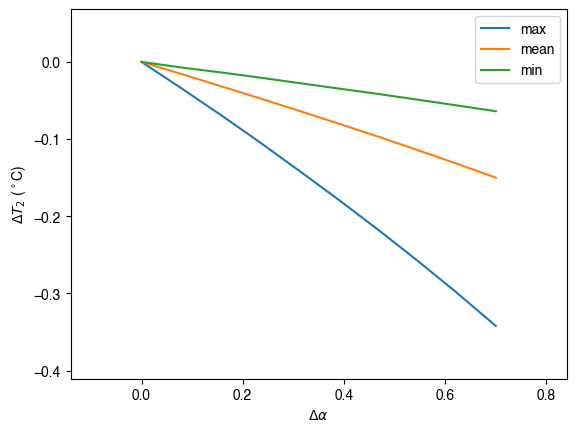

In [27]:
# plot the temperature difference
ax_temp_diff = df_res_alb_T2_diff.loc[["max", "mean", "min"]].T.plot()
_ = ax_temp_diff.set_ylabel(r"$\Delta T_2$ ($^\circ$C)")
_ = ax_temp_diff.set_xlabel(r"$\Delta\alpha$")
ax_temp_diff.margins(x=0.2, y=0.2)


## Background climate: air temperature

### Examine the monthly climatology of air temperature loaded from the sample dataset

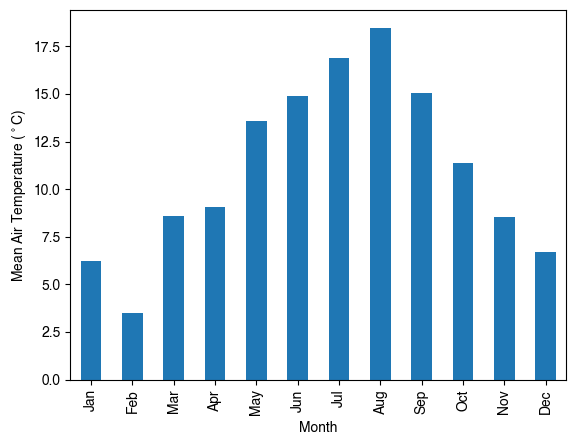

In [28]:
df_plot = df_forcing.Tair.loc["2012"].resample("1m").mean()
ax_temp = df_plot.plot.bar(color="tab:blue")
_ = ax_temp.set_xticklabels(df_plot.index.strftime("%b"))
_ = ax_temp.set_ylabel(r"Mean Air Temperature ($^\circ$C)")
_ = ax_temp.set_xlabel("Month")

### Construct a function to perform parallel `supy` simulations with specified `diff_airtemp_test`: the difference in air temperature between the one used in simulation and loaded from sample dataset.

<div class="alert alert-info">

Note

forcing data `df_forcing` has different data structure from `df_state_init`; so we need to modify `run_supy_mgrids` to implement a `run_supy_mclims` for different climate scenarios*

</div> 

Let's start the implementation of `run_supy_mclims` with a small problem of four forcing groups (i.e., climate scenarios), where the air temperatures differ from the baseline scenario with a constant bias.

In [29]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc["2012 1":"2012 7"].copy()
df_state_init_test = df_state_init.copy()

In [30]:
from concurrent.futures import ThreadPoolExecutor

# create a dict with four forcing conditions as a test
n_test = 4
list_TairDiff_test = np.linspace(0.0, 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy() for tairdiff in list_TairDiff_test
}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, "Tair"] += tairdiff


# Helper function for parallel simulation
def run_sim_oop(key, df_forcing, df_state_init, logging_level=90):
    sim = SUEWSSimulation.from_state(df_state_init)
    sim.update_forcing(df_forcing)
    sim.run(logging_level=logging_level)
    return (key, sim.results)


# Run simulations in parallel using Python's built-in ThreadPoolExecutor
# Note: Using threads (not processes) to work in Jupyter notebooks
with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(run_sim_oop, k, df, df_state_init_test, 90)
        for k, df in dict_df_forcing_x.items()
    ]
    results = {key: result for key, result in [f.result() for f in futures]}

df_res_tairdiff_test0 = pd.concat(
    results,
    keys=list_TairDiff_test,
    names=["tairdiff"],
)
df_res_tairdiff_test = df_res_tairdiff_test0.reset_index("grid", drop=True)

In [31]:
# test the performance of a parallel run
t0 = time()
# Execute the parallel simulation (already done in cell above)
t1 = time()
t_par = t1 - t0
print(f"Execution time: {t_par:.2f} s")

Execution time: 0.00 s


In [32]:
# function for multi-climate `run_supy` using OOP interface and built-in parallelization
def run_supy_mclims(df_state_init, dict_df_forcing_mclims):
    from concurrent.futures import ThreadPoolExecutor

    # Helper function for parallel simulation
    def run_sim_oop(key, df_forcing, df_state_init, logging_level=90):
        sim = SUEWSSimulation.from_state(df_state_init)
        sim.update_forcing(df_forcing)
        sim.run(logging_level=logging_level)
        return (key, sim.results)

    # Run simulations in parallel using threads
    # Note: Using threads (not processes) to work in Jupyter notebooks
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(run_sim_oop, k, df, df_state_init, 90)
            for k, df in dict_df_forcing_mclims.items()
        ]
        results = {key: result for key, result in [f.result() for f in futures]}

    df_output_mclims0 = pd.concat(
        results,
        keys=list(dict_df_forcing_mclims.keys()),
        names=["clm"],
    )
    df_output_mclims = df_output_mclims0.reset_index("grid", drop=True)

    return df_output_mclims

### Construct `dict_df_forcing_x` with multiple forcing `DataFrame`s

In [33]:
# save loaded sample datasets
df_forcing_part_test = df_forcing.loc["2012 1":"2012 7"].copy()
df_state_init_test = df_state_init.copy()

# create a dict with a number of forcing conditions
n_test = 12  # can be set with a smaller value to save simulation time
list_TairDiff_test = np.linspace(0.0, 2, n_test).round(2)
dict_df_forcing_x = {
    tairdiff: df_forcing_part_test.copy() for tairdiff in list_TairDiff_test
}
for tairdiff in dict_df_forcing_x:
    dict_df_forcing_x[tairdiff].loc[:, "Tair"] += tairdiff

### Perform simulations

In [34]:
# run parallel simulations using `run_supy_mclims`
t0 = time()
df_airtemp_test_x = run_supy_mclims(df_state_init_test, dict_df_forcing_x)
t1 = time()
t_par = t1 - t0
print(f"Execution time: {t_par:.2f} s")

Execution time: 72.65 s


### Examine the results

In [35]:
df_airtemp_test = df_airtemp_test_x.SUEWS.unstack(0)
df_temp_diff = df_airtemp_test.T2.transform(lambda x: x - df_airtemp_test.T2[0.0])
df_temp_diff_ana = df_temp_diff.loc["2012 7"]
df_temp_diff_stat = df_temp_diff_ana.describe().loc[["max", "mean", "min"]].T

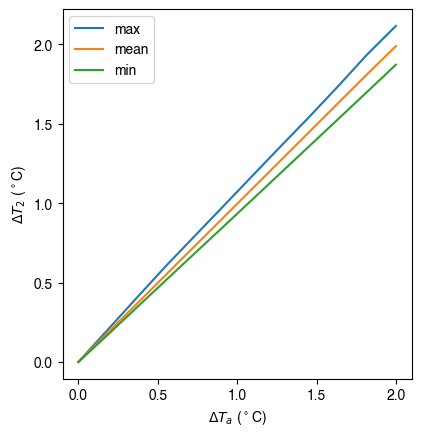

In [36]:
ax_temp_diff_stat = df_temp_diff_stat.plot()
_ = ax_temp_diff_stat.set_ylabel(r"$\Delta T_2$ ($^\circ$C)")
_ = ax_temp_diff_stat.set_xlabel(r"$\Delta T_{a}$ ($^\circ$C)")
ax_temp_diff_stat.set_aspect("equal")

The $T_{2}$ results indicate the increased $T_{a}$ has different impacts on the $T_{2}$ metrics (minimum, mean and maximum) but all increase linearly with $T_{a}.$ The maximum $T_{2}$ has the stronger response compared to the other metrics.